In [6]:
from langchain_neo4j import Neo4jGraph, GraphCypherQAChain, Neo4jVector
import os
from langchain_core.documents import Document
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_experimental.graph_transformers import LLMGraphTransformer

import pprint

In [7]:
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [8]:
graph = Neo4jGraph(url=os.getenv("NEO4J_URI"), username=os.getenv(
    "USERNAME"), password=os.getenv("PASSWORD"))

In [9]:
file_path = "../public/Elon_Musk.pdf"
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [10]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(pages)

In [11]:
text = """"Elon Reeve Musk FRS (/ˈiːlɒn/ EE-lon; born June 28, 1971) is a businessman, known for his leadership of Tesla, SpaceX, X (formerly Twitter), and the Department of Government Efficiency (DOGE). Musk has been the wealthiest person in the world since 2021; as of May 2025, Forbes estimates his net worth to be US$424.7 billion.
Born to a wealthy family in Pretoria, South Africa, Musk emigrated in 1989 to Canada. He received bachelor's degrees from the University of Pennsylvania in 1997 before moving to California, United States, to pursue business ventures. In 1995, Musk co-founded the software company Zip2. Following its sale in 1999, he co-founded X.com, an online payment company that later merged to form PayPal, which was acquired by eBay in 2002. That year, Musk also became an American citizen.
In 2002, Musk founded the space technology company SpaceX, becoming its CEO and chief engineer; the company has since led innovations in reusable rockets and commercial spaceflight. Musk joined the automaker Tesla as an early investor in 2004 and became its CEO and product architect in 2008; it has since become a leader in electric vehicles. In 2015, he co-founded OpenAI to advance artificial intelligence (AI) research but later left; growing discontent with the organization's direction and their leadership in the AI boom in the 2020s led him to establish xAI. In 2022, he acquired the social network Twitter, implementing significant changes and rebranding it as X in 2023. His other businesses include the neurotechnology company Neuralink, which he co-founded in 2016, and the tunneling company the Boring Company, which he founded in 2017.
Musk was the largest donor in the 2024 U.S. presidential election, and is a supporter of global far-right figures, causes, and political parties. In early 2025, he served as senior advisor to United States president Donald Trump and as the de facto head of DOGE. After a public feud with Trump, Musk left the Trump administration and announced he was creating his own political party, the America Party.
Musk's political activities, views, and statements have made him a polarizing figure, especially following the COVID-19 pandemic. He has been criticized for making unscientific and misleading statements, including COVID-19 misinformation and promoting conspiracy theories, and affirming antisemitic, racist, and transphobic comments. His acquisition of Twitter was controversial due to a subsequent increase in hate speech and the spread of misinformation on the service. His role in the second Trump administration attracted public backlash, particularly in response to DOGE. """

In [12]:
chunks = text_splitter.split_documents([Document(page_content=text)])
chunks

[Document(metadata={}, page_content='"Elon Reeve Musk FRS (/ˈiːlɒn/ EE-lon; born June 28, 1971) is a businessman, known for his leadership of Tesla, SpaceX, X (formerly Twitter), and the Department of Government Efficiency (DOGE). Musk has been the wealthiest person in the world since 2021; as of May 2025, Forbes estimates his net worth to be US$424.7 billion.'),
 Document(metadata={}, page_content="Born to a wealthy family in Pretoria, South Africa, Musk emigrated in 1989 to Canada. He received bachelor's degrees from the University of Pennsylvania in 1997 before moving to California, United States, to pursue business ventures. In 1995, Musk co-founded the software company Zip2. Following its sale in 1999, he co-founded X.com, an online payment company that later merged to form PayPal, which was acquired by eBay in 2002. That year, Musk also became an American citizen."),
 Document(metadata={}, page_content="In 2002, Musk founded the space technology company SpaceX, becoming its CEO a

In [13]:
llm = ChatGoogleGenerativeAI(api_key=os.getenv(
    "GEMINI_API_KEY"), model="gemini-2.5-flash")

In [14]:
graph_transformer = LLMGraphTransformer(
    llm=llm)

In [15]:
data = await graph_transformer.aconvert_to_graph_documents(chunks)

In [ ]:
graph.add_graph_documents(data)

In [12]:
embeddings = GoogleGenerativeAIEmbeddings(
    google_api_key=os.getenv("GEMINI_API_KEY"),
    model="models/embedding-001"
)

In [25]:
try:
    graph.query("DROP INDEX vector IF EXISTS")
    print("Existing vector index dropped successfully")
except Exception as e:
    print(f"Error dropping index: {e}")

Existing vector index dropped successfully


In [13]:
graph.query("match (n:Person)-[j:CO_FOUNDED]->(m) return n, j, m")

[{'n': {'id': 'Musk'},
  'j': ({'id': 'Musk'}, 'CO_FOUNDED', {'id': 'Zip2'}),
  'm': {'id': 'Zip2'}},
 {'n': {'id': 'Musk'},
  'j': ({'id': 'Musk'}, 'CO_FOUNDED', {'id': 'X.Com'}),
  'm': {'id': 'X.Com'}},
 {'n': {'id': 'Musk'},
  'j': ({'id': 'Musk'}, 'CO_FOUNDED', {'id': 'Openai'}),
  'm': {'id': 'Openai'}},
 {'n': {'id': 'Unnamed Person'},
  'j': ({'id': 'Unnamed Person'}, 'CO_FOUNDED', {'id': 'Neuralink'}),
  'm': {'id': 'Neuralink'}}]

In [40]:
chain = GraphCypherQAChain.from_llm(
    llm, graph=graph, verbose=True,
    allow_dangerous_requests=True
)

chain.invoke("Musk is ceo of which company?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person {id: 'Musk'})-[:CEO_OF]->(c:Company)
RETURN c.id

Full Context:
[{'c.id': 'Spacex'}, {'c.id': 'Tesla'}]

> Finished chain.


{'query': 'Musk is ceo of which company?',
 'result': 'Musk is ceo of Spacex, Tesla.'}

In [15]:
graph.get_structured_schema

{'node_props': {'Location': [{'property': 'id', 'type': 'STRING'}],
  'Event': [{'property': 'id', 'type': 'STRING'}],
  'Organization': [{'property': 'id', 'type': 'STRING'}],
  'Person': [{'property': 'id', 'type': 'STRING'}],
  'Concept': [{'property': 'id', 'type': 'STRING'}],
  'Occupation': [{'property': 'id', 'type': 'STRING'}],
  'Date': [{'property': 'id', 'type': 'STRING'}],
  'Monetary value': [{'property': 'id', 'type': 'STRING'}],
  'University': [{'property': 'id', 'type': 'STRING'}],
  'Company': [{'property': 'id', 'type': 'STRING'}],
  'Technology': [{'property': 'id', 'type': 'STRING'}],
  'Field of study': [{'property': 'id', 'type': 'STRING'}],
  'Year': [{'property': 'id', 'type': 'STRING'}],
  'Election': [{'property': 'id', 'type': 'STRING'}],
  'Movement': [{'property': 'id', 'type': 'STRING'}],
  'Government': [{'property': 'id', 'type': 'STRING'}],
  'Political party': [{'property': 'id', 'type': 'STRING'}],
  'Administration': [{'property': 'id', 'type': 'STR

In [26]:
vector_index = Neo4jVector.from_existing_graph(
    username=os.getenv("USERNAME"),
    password=os.getenv("PASSWORD"),
    embedding=embeddings,
    search_type="hybrid",
    node_label="Document",
    text_node_properties=["text"],
    embedding_node_property="embedding"
)

In [32]:
vector_index.similarity_search_with_relevance_scores("elon musk founded which companies?")

[(Document(metadata={}, page_content="In 2002, Musk founded the space technology company SpaceX, becoming its CEO and chief engineer; the company has since led innovations in reusable rockets and commercial spaceflight. Musk joined the automaker Tesla as an early investor in 2004 and became its CEO and product architect in 2008; it has since become a leader in electric vehicles. In 2015, he co-founded OpenAI to advance artificial intelligence (AI) research but later left; growing discontent with the organization's direction and"),
  1.0),
 (Document(metadata={}, page_content="Born to a wealthy family in Pretoria, South Africa, Musk emigrated in 1989 to Canada. He received bachelor's degrees from the University of Pennsylvania in 1997 before moving to California, United States, to pursue business ventures. In 1995, Musk co-founded the software company Zip2. Following its sale in 1999, he co-founded X.com, an online payment company that later merged to form PayPal, which was acquired by 

In [16]:

import pickle

with open("graph_data.pkl", "wb") as file:
    pickle.dump(data, file)


In [18]:
with open("graph_data.pkl", "rb") as file:
    loaded_data = pickle.load(file)

loaded_data

[GraphDocument(nodes=[Node(id='Elon Reeve Musk', type='Person', properties={}), Node(id='Tesla', type='Organization', properties={}), Node(id='Spacex', type='Organization', properties={}), Node(id='X', type='Organization', properties={}), Node(id='Twitter', type='Organization', properties={}), Node(id='Department Of Government Efficiency', type='Organization', properties={}), Node(id='Doge', type='Organization', properties={}), Node(id='June 28, 1971', type='Date', properties={}), Node(id='2021', type='Year', properties={}), Node(id='May 2025', type='Date', properties={}), Node(id='Forbes', type='Organization', properties={}), Node(id='Us$424.7 Billion', type='Financial value', properties={})], relationships=[Relationship(source=Node(id='Elon Reeve Musk', type='Person', properties={}), target=Node(id='Tesla', type='Organization', properties={}), type='LEADS', properties={}), Relationship(source=Node(id='Elon Reeve Musk', type='Person', properties={}), target=Node(id='Spacex', type='Org

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.Graph()

for graph_doc in data:
    for node in graph_doc.nodes:
        g.add_node(node.id, type=node.type, **node.properties)
    
    for relationship in graph_doc.relationships:
        g.add_edge(
            relationship.source.id, 
            relationship.target.id, 
            relationship=relationship.type,
            **relationship.properties
        )

Node types found: {'Country', 'Date', 'Political party', 'Year', 'Social network', 'Technology', 'State', 'Field', 'Administration', 'Group', 'Event', 'Concept', 'Government body', 'University', 'Company', 'Person', 'Financial value', 'City', 'Organization'}


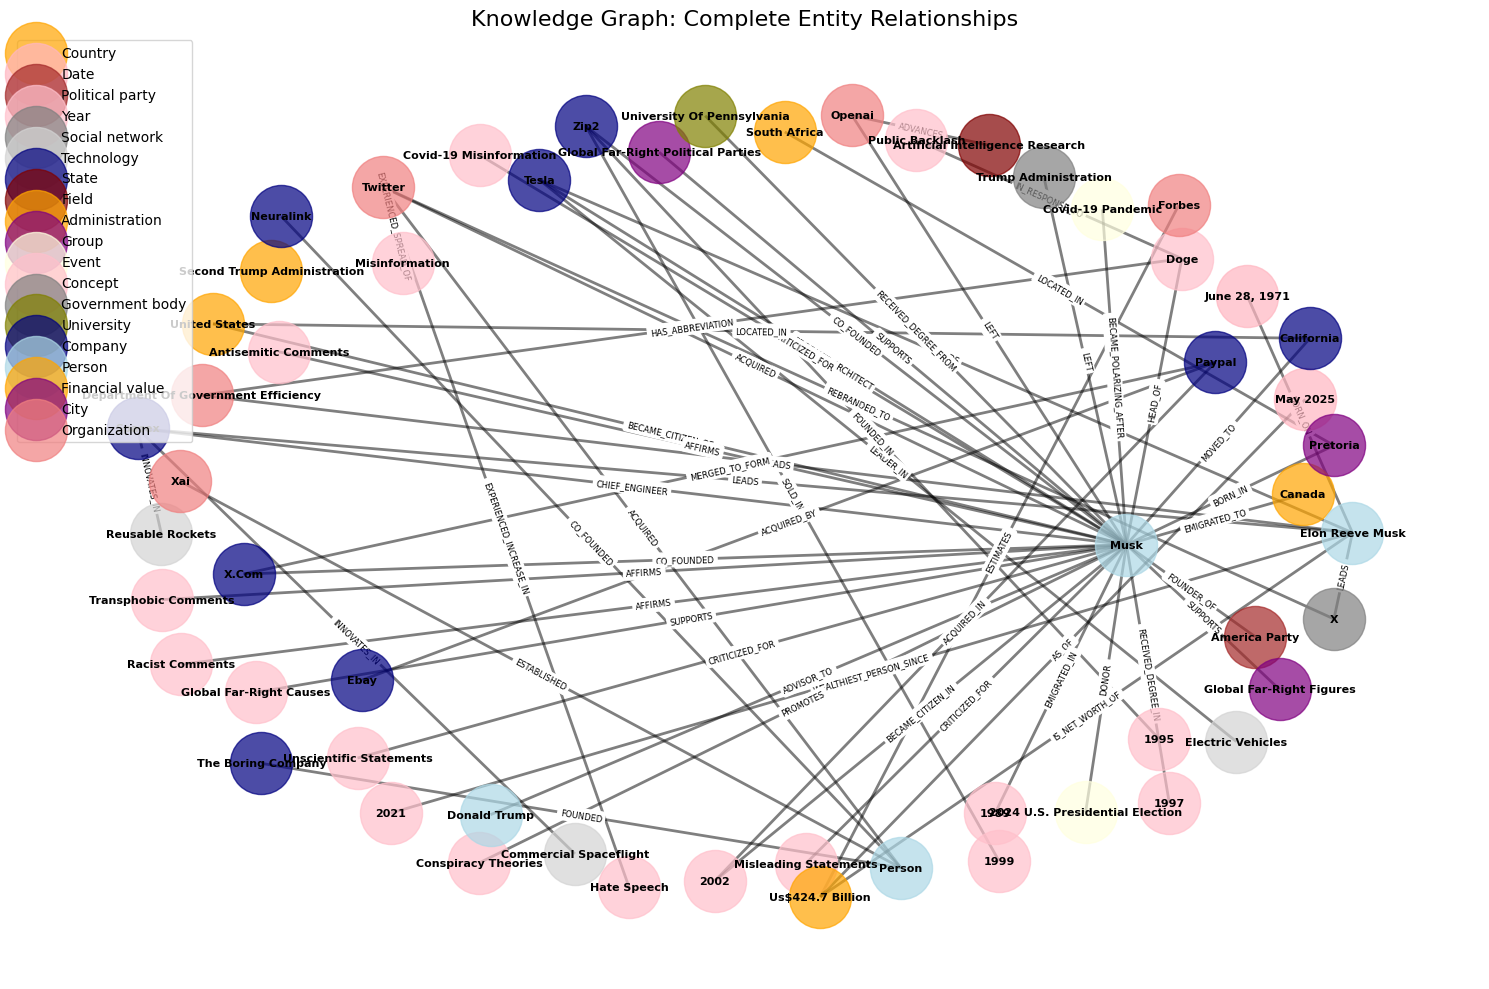

Number of nodes: 56
Number of edges: 59


In [20]:
plt.figure(figsize=(15, 10))

pos = nx.spring_layout(g, k=3, iterations=50)

node_types = set(attr.get('type', 'Unknown') for _, attr in g.nodes(data=True))
print(f"Node types found: {node_types}")

color_map = {
    'Person': 'lightblue',
    'Organization': 'lightcoral',
    'Location': 'lightgreen',
    'Event': 'lightyellow',
    'Date': 'lightpink',
    'Technology': 'lightgray',
    'Unknown': 'white'
}

additional_colors = ['orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'navy', 'maroon']
for i, node_type in enumerate(node_types):
    if node_type not in color_map:
        color_map[node_type] = additional_colors[i % len(additional_colors)]

for node_type in node_types:
    nodes_of_type = [node for node, attr in g.nodes(data=True) if attr.get('type') == node_type]
    if nodes_of_type:
        nx.draw_networkx_nodes(g, pos, nodelist=nodes_of_type, 
                             node_color=color_map[node_type],
                             node_size=2000, alpha=0.7, label=node_type)

nx.draw_networkx_edges(g, pos, alpha=0.5, width=2)

nx.draw_networkx_labels(g, pos, font_size=8, font_weight='bold')

edge_labels = nx.get_edge_attributes(g, 'relationship')
nx.draw_networkx_edge_labels(g, pos, edge_labels, font_size=6)

plt.title("Knowledge Graph: Complete Entity Relationships", size=16)
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Number of nodes: {g.number_of_nodes()}")
print(f"Number of edges: {g.number_of_edges()}")

In [ ]:
import plotly.graph_objects as go

pos = nx.spring_layout(g, k=2, iterations=50)

edge_x = []
edge_y = []
for u, v in g.edges():
    edge_x += [pos[u][0], pos[v][0], None]
    edge_y += [pos[u][1], pos[v][1], None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x, node_y = zip(*[pos[n] for n in g.nodes()])

node_text = []
node_colors = []
for node in g.nodes():
    node_info = g.nodes[node]
    node_type = node_info.get('type', 'Unknown')
    hover_text = f"<b>{node}</b><br>Type: {node_type}"

    for key, value in node_info.items():
        if key != 'type':
            hover_text += f"<br>{key}: {value}"
    
    node_text.append(hover_text)
    
    color_map = {
        'Person': '#FF6B6B',
        'Organization': '#4ECDC4',
        'Location': '#45B7D1',
        'Event': '#96CEB4',
        'Date': '#FFEAA7',
        'Technology': '#DDA0DD',
        'Unknown': '#95A5A6'
    }
    node_colors.append(color_map.get(node_type, '#95A5A6'))

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        size=15,
        color=node_colors,
        line=dict(width=2, color='white')
    ))

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Interactive Knowledge Graph',
                    font_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(
                        text="Hover over nodes for details",
                        showarrow=False,
                        xref="paper", yref="paper",
                        x=0.005, y=-0.002,
                        xanchor='left', yanchor='bottom',
                        font=dict(color='#888', size=12)
                    )],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    plot_bgcolor='white'
                ))

fig.show()

print(f"Interactive graph created with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges")

Interactive graph created with 56 nodes and 59 edges
